In [ ]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import indicators
import warnings

# To ignore all warnings
warnings.filterwarnings("ignore")

# Check TensorFlow version
print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.15.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Bitcoin 5-min data loading

In [ ]:
def data_preprocess(file_name):
    data = pd.read_csv(file_name)
    data = data.sort_values(by = ['date'], ascending = True, ignore_index = True)
    data_5min = data[data['date'].str[-4:-3].isin(['0', '5'])]
    return data_5min

In [ ]:
data_2122_5min = data_preprocess('/content/drive/My Drive/Colab Notebooks/BTC-2021min.csv')
data_20_5min = data_preprocess('/content/drive/My Drive/Colab Notebooks/BTC-2020min.csv')
data_19_5min = data_preprocess('/content/drive/My Drive/Colab Notebooks/BTC-2019min.csv')
data_18_5min = data_preprocess('/content/drive/My Drive/Colab Notebooks/BTC-2018min.csv')
data_17_5min = data_preprocess('/content/drive/My Drive/Colab Notebooks/BTC-2017min.csv')

In [ ]:
quarter_size = len(data_2122_5min) // 4
start_index = 3 * quarter_size

last_quarter_data = data_2122_5min.iloc[start_index:]

In [ ]:
last_quarter_data.index = last_quarter_data.date

In [ ]:
last_quarter_data = last_quarter_data[['date','close']]

In [ ]:
lags = 5  # Number of lagged values to use
for i in range(1, lags + 1):
    last_quarter_data[f'Close_Lag_{i}'] = last_quarter_data['close'].shift(i)

# Drop rows with missing values
last_quarter_data.dropna(inplace=True)

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Prepare the data
lags = 5  # Number of lagged values to use
for i in range(1, lags + 1):
    last_quarter_data[f'Close_Lag_{i}'] = last_quarter_data['close'].shift(i)

# Drop rows with missing values
last_quarter_data.dropna(inplace=True)

# Split the data into features (X) and target variable (y)
X = last_quarter_data.drop(['close', 'date'], axis=1)
y = last_quarter_data['close']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define the XGBoost model
model = XGBRegressor()

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions
predictions = best_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print("Best Hyperparameters:", best_params)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)



Best Hyperparameters: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 300}
Mean Absolute Error (MAE): 127.91049920160495
Root Mean Squared Error (RMSE): 206.76926030229262


In [ ]:
# Make predictions
predictions = best_model.predict(X_test)

# Calculate MAPE
absolute_percentage_errors = np.abs((predictions - y_test) / y_test)
mape = np.mean(absolute_percentage_errors) * 100

print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Absolute Percentage Error (MAPE): 0.3126024755263179


In [ ]:
last_quarter_data

,date,close,Close_Lag_1,Close_Lag_2,Close_Lag_3,Close_Lag_4,Close_Lag_5
date,,,,,,,
2021-11-15 03:40:00,2021-11-15 03:40:00,65808.03,65729.04,65740.64,65687.54,65673.19,65792.06
2021-11-15 03:45:00,2021-11-15 03:45:00,65852.21,65808.03,65729.04,65740.64,65687.54,65673.19
2021-11-15 03:50:00,2021-11-15 03:50:00,65743.86,65852.21,65808.03,65729.04,65740.64,65687.54
2021-11-15 03:55:00,2021-11-15 03:55:00,65724.45,65743.86,65852.21,65808.03,65729.04,65740.64
2021-11-15 04:00:00,2021-11-15 04:00:00,65789.16,65724.45,65743.86,65852.21,65808.03,65729.04
...,...,...,...,...,...,...,...
2022-03-01 03:20:00,2022-03-01 03:20:00,42984.45,42986.98,43088.90,43088.70,43161.21,43137.22
2022-03-01 03:25:00,2022-03-01 03:25:00,43002.30,42984.45,42986.98,43088.90,43088.70,43161.21
2022-03-01 03:30:00,2022-03-01 03:30:00,43093.52,43002.30,42984.45,42986.98,43088.90,43088.70


In [ ]:
len(predictions)

6106

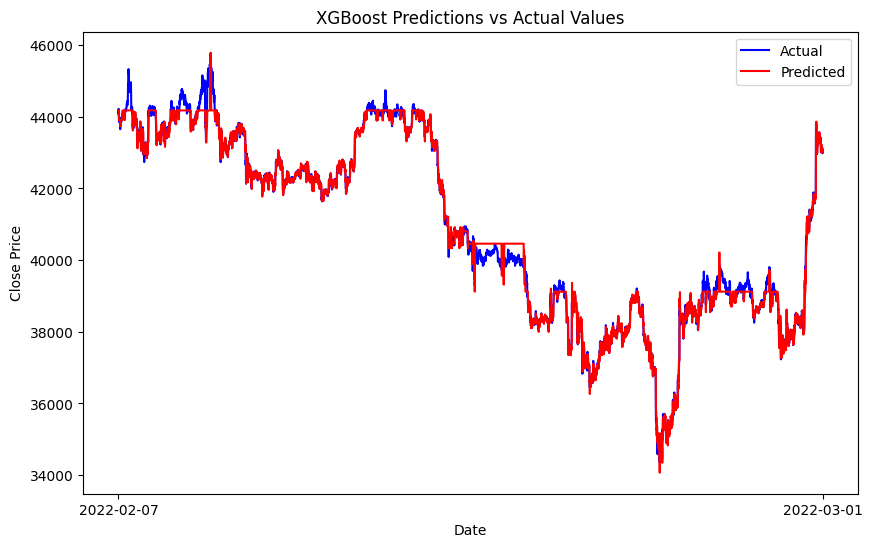

In [ ]:
import matplotlib.pyplot as plt

# Convert index to datetime format
y_test.index = pd.to_datetime(y_test.index)

# Get start date and end date of the x-axis
start_date = y_test.index[0].strftime('%Y-%m-%d')
end_date = y_test.index[-1].strftime('%Y-%m-%d')

# Plot predictions and y_test
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, predictions, label='Predicted', color='red')
plt.title('XGBoost Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks([y_test.index[0], y_test.index[-1]], [start_date, end_date])
plt.legend()
plt.show()